In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator


In [2]:
meta = pd.read_csv("meta_train.csv")
meta['image_id'] = meta['image_id'].str.replace('.jpg', '', regex=False).str.lower()

label_encoder = LabelEncoder()
meta['variety_encoded'] = label_encoder.fit_transform(meta['variety'])

variety_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Variety label map:", variety_map)


Variety label map: {'ADT45': np.int64(0), 'AndraPonni': np.int64(1), 'AtchayaPonni': np.int64(2), 'IR20': np.int64(3), 'KarnatakaPonni': np.int64(4), 'Onthanel': np.int64(5), 'Ponni': np.int64(6), 'RR': np.int64(7), 'Surya': np.int64(8), 'Zonal': np.int64(9)}


In [3]:
IMAGE_ROOT = r"C:\Users\bazen\PyCharmMiscProject\.venv\train_images"

image_index = {}
for path in glob.glob(os.path.join(IMAGE_ROOT, "*", "*.jpg")):
    image_id = os.path.basename(path).split('.')[0].lower()
    image_index[image_id] = path

IMG_SIZE = 128

def load_and_process_image(img_id):
    path = image_index.get(img_id)
    if not path:
        raise FileNotFoundError(f"{img_id} not found in index!")
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    return img_to_array(img) / 255.0

x_data = np.array([load_and_process_image(iid) for iid in meta['image_id']])
y_data = np.array(meta['variety_encoded'])

print("Image data shape:", x_data.shape)
print("Labels shape:", y_data.shape)


Image data shape: (10407, 128, 128, 3)
Labels shape: (10407,)


In [4]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_data), y=y_data)
class_weights_dict = dict(enumerate(class_weights))


In [5]:
class_counts = Counter(y_data)
minority_classes = [cls for cls, count in class_counts.items() if count < 100]

# Get the encoded ID for Onthanel
onthanel_class_id = label_encoder.transform(['Onthanel'])[0]

def augment_minority_classes(x, y, datagen, default_multiplier=5):
    x_aug, y_aug = [], []
    for cls in minority_classes:
        idxs = np.where(y == cls)[0]

        # 🔽 Reduce multiplier specifically for Onthanel
        multiplier = 2 if cls == onthanel_class_id else default_multiplier

        for idx in idxs:
            for _ in range(multiplier):
                augmented = datagen.random_transform(x[idx])
                x_aug.append(augmented)
                y_aug.append(cls)

    return np.array(x_aug), np.array(y_aug)


In [6]:
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []
datagen = ImageDataGenerator(horizontal_flip=True)


In [7]:
for fold, (train_idx, val_idx) in enumerate(skf.split(x_data, y_data)):
    print(f"\n📂 Fold {fold+1}/{k}")

    x_train, x_val = x_data[train_idx], x_data[val_idx]
    y_train, y_val = y_data[train_idx], y_data[val_idx]

    # ✅ Augment minority classes
    x_aug, y_aug = augment_minority_classes(x_train, y_train, datagen)
    x_train = np.concatenate([x_train, x_aug])
    y_train = np.concatenate([y_train, y_aug])

    # Build model
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(variety_map), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # ✅ Train with class weights
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_val, y_val),
        epochs=30,
        class_weight=class_weights_dict,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(x_val, y_val)
    accuracies.append(val_acc)
    print(f"✅ Fold {fold+1} validation accuracy: {val_acc:.4f}")



📂 Fold 1/5


C:\Users\bazen\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\bazen\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.0334 - loss: 4.2524 - val_accuracy: 0.0754 - val_loss: 2.3326
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 63s 217ms/step - accuracy: 0.1431 - loss: 1.9174 - val_accuracy: 0.2992 - val_loss: 1.7353
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 62s 229ms/step - accuracy: 0.3446 - loss: 1.2302 - val_accuracy: 0.3026 - val_loss: 1.8022
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.5016 - loss: 0.7527 - val_accuracy: 0.4750 - val_loss: 1.3725
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.6680 - loss: 0.3935 - val_accuracy: 0.5346 - val_loss: 1.3410
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 55s 205ms/step - accuracy: 0.7161 - loss: 0.3189 - val_accuracy: 0.2901 - val_loss: 2.0803
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 58s 217ms/step - accuracy: 0.5933 - loss: 0.4777 - val_accuracy: 0.7517 - val_loss: 0.6622
Epoch 8/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.8323 - loss: 0.


📈 Cross-Validation Results:
Average Accuracy: 0.8654
Standard Deviation: 0.0276


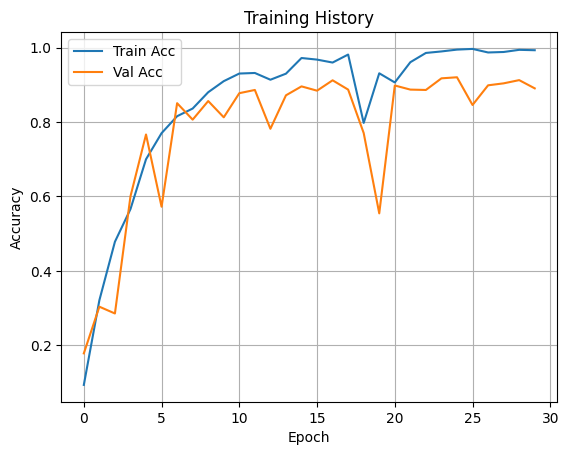

In [8]:
print("\n📈 Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


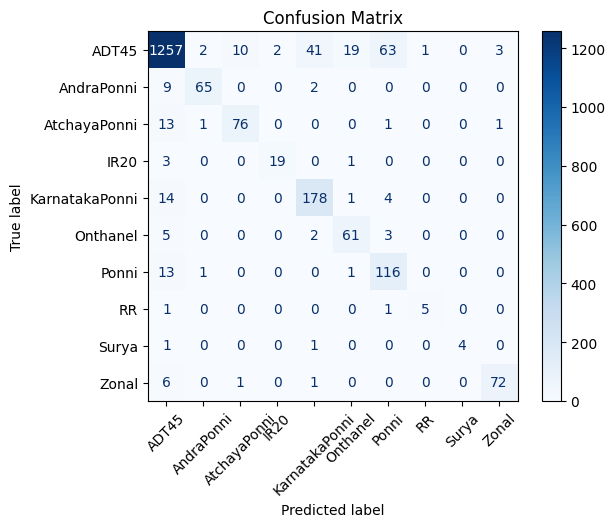

                precision    recall  f1-score   support

         ADT45       0.95      0.90      0.92      1398
    AndraPonni       0.94      0.86      0.90        76
  AtchayaPonni       0.87      0.83      0.85        92
          IR20       0.90      0.83      0.86        23
KarnatakaPonni       0.79      0.90      0.84       197
      Onthanel       0.73      0.86      0.79        71
         Ponni       0.62      0.89      0.73       131
            RR       0.83      0.71      0.77         7
         Surya       1.00      0.67      0.80         6
         Zonal       0.95      0.90      0.92        80

      accuracy                           0.89      2081
     macro avg       0.86      0.83      0.84      2081
  weighted avg       0.90      0.89      0.89      2081



In [9]:
# Predict classes for validation set
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix with improved colormap
cm = confusion_matrix(y_val, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')  # 👈 only change here
plt.title("Confusion Matrix")  # Optional: Add a title
plt.show()

# Print classification report
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))
